In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import catboost as ctb 

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

In [2]:
train_parquet = "/home/lishi/projects/Competition/kaggle_2023/data/train_add_daily_features.parquet"

prices =  ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]
ta_indicators = ['ema', 'rsi', 'cci', 'mfi', 'ad_osc', 'macd', 'macdhist', 'macdsignal']

stock_labels = [0, 1, 2]

df_all = pd.read_parquet(train_parquet)

df_all = df_all[~df_all['target'].isnull()].reset_index(drop=True)
df_all = df_all.drop(columns=['row_id', 'time_id'])
df_all['imbalance_buy_sell_flag'] = df_all['imbalance_buy_sell_flag'].replace({-1: 0, 1: 1})

In [3]:
shenxian = df_all[df_all['stock_label']==0]['stock_id'].unique()
shenxian 

array([  0,   3,   4,   7,   8,   9,  10,  12,  13,  14,  15,  17,  20,
        21,  23,  24,  25,  26,  27,  29,  30,  32,  34,  35,  36,  37,
        38,  39,  40,  41,  43,  44,  45,  47,  48,  49,  52,  53,  54,
        55,  57,  58,  63,  65,  66,  68,  71,  72,  73,  75,  76,  77,
        83,  84,  88,  90,  95,  98,  99, 104, 105, 106, 109, 110, 112,
       113, 116, 117, 120, 121, 122, 123, 126, 128, 130, 131, 132, 133,
       136, 137, 139, 140, 141, 142, 144, 145, 148, 149, 151, 152, 154,
       157, 159, 160, 163, 164, 165, 166, 167, 168, 169, 170, 171, 175,
       178, 179, 181, 182, 183, 185, 186, 187, 189, 190, 191, 192, 193,
       195, 196, 198], dtype=int16)

In [3]:
shenxian = df_all[df_all['stock_label']==1]['stock_id'].unique()
shenxian 

array([ 11,  31,  70,  80,  82,  85,  86,  92, 100, 101, 129, 158, 174,
       177, 180,  78, 153], dtype=int16)

In [4]:
shenxian = df_all[df_all['stock_label']==2]['stock_id'].unique()
shenxian 

array([  1,   2,   5,   6,  16,  18,  19,  22,  28,  33,  42,  46,  50,
        51,  56,  59,  60,  61,  62,  64,  67,  74,  81,  87,  89,  91,
        93,  94,  96,  97, 103, 107, 108, 111, 114, 115, 118, 119, 124,
       125, 127, 134, 138, 143, 146, 147, 155, 161, 162, 172, 173, 176,
       184, 188, 194, 197,  69, 156, 150, 199,  79, 135, 102], dtype=int16)

In [5]:
feature_cols = [x for x in df_all.columns if x not in ['target', 'date_id', 'row_id'] + ta_indicators]
category_cols = ["stock_id", "seconds_in_bucket", 'imbalance_buy_sell_flag', 'stock_label']

wap_shift = df_all.groupby(['date_id', 'stock_id'])['wap'].shift(-6)
wap_shift.name = 'wap_shift'
df_all = pd.concat([df_all, wap_shift], axis=1)
df_all['wap_chg'] = df_all['wap_shift'] / df_all['wap'] - 1

df_all = df_all.dropna().reset_index(drop=True)

dates_list = df_all['date_id'].unique()

k_fold = KFold(n_splits=5, shuffle=False, random_state=None)
kf_split = list(k_fold.split(dates_list))

In [6]:
lgb_params = {
    'boosting_type': 'gbdt',
    'learning_rate': 0.009, #0.009,#0.018,
    'max_depth': 12,#9,
    'n_estimators': 800,#600,
    'num_leaves': 1024,#440,
    'objective': 'mae',
    'random_state': 42,
    'reg_alpha': 0.01,
    'reg_lambda': 0.01,
    'early_stopping_rounds': 100,
    'num_threads': 16,
    'importance_type': 'gain',
    'verbose': -1,
    }

In [7]:
# choose_stock = 122 
# n_split = 5

lgb_model_collection = {}


for choose_stock in df_all['stock_id'].unique():

    print(f"Stock {choose_stock}")

    df = df_all[df_all.stock_id == choose_stock].reset_index(drop=True)

    raw_wap = df['wap'].copy()
    
    scale_cols = [x for x in feature_cols if x not in category_cols]
    scaler = StandardScaler().fit(df[scale_cols])
    df[scale_cols] = scaler.transform(df[scale_cols])

    target_col ='wap_chg'

    mae_list = []
    lgb_models = []

    for fold, (train_idx, valid_idx) in enumerate(kf_split):
        
        print(f"Fold {fold+1}")

        train_dates = dates_list[train_idx]
        
        half_valid = int(len(valid_idx)/2)
        valid_dates_1 = dates_list[valid_idx[:half_valid]]
        valid_dates_2 = dates_list[valid_idx[half_valid:]]
        
        print(f"Valid Dates 1: {valid_dates_1[0]} - {valid_dates_1[-1]}")
        print(f"Valid Dates 2: {valid_dates_2[0]} - {valid_dates_2[-1]}")
        
        # split train and valid set
        df_train_fold = df[df["date_id"].isin(train_dates)].reset_index(drop=True)
        df_valid_fold_1 = df[df["date_id"].isin(valid_dates_1)].reset_index(drop=True)
        df_valid_fold_2 = df[df["date_id"].isin(valid_dates_2)].reset_index(drop=True)

        print("Start training LightGBM...")
        lgb_model = lgb.LGBMRegressor(**lgb_params)
        lgb_model.fit(
            df_train_fold[feature_cols].values, 
            df_train_fold[target_col].values,
            eval_set=[(
                df_valid_fold_1[feature_cols].values, 
                df_valid_fold_1[target_col].values
                )],
            feature_name = feature_cols,
            categorical_feature = category_cols,
            callbacks=[lgb.callback.log_evaluation(period=100)],
            )
        
        valid_pred_lgb = lgb_model.predict(df_valid_fold_2[feature_cols].values)
        pred_wap = (valid_pred_lgb + 1) * raw_wap[df["date_id"].isin(valid_dates_2)]

        valid_mae_lgb = mean_absolute_error(df_valid_fold_2['wap_shift'].values, pred_wap) * 1e4
        mae_list.append(valid_mae_lgb)
        print(f"Valid MAE: {valid_mae_lgb}")

        lgb_models.append(lgb_model)

    print(f"Average MAE: {np.mean(mae_list)}")
    lgb_model_collection[choose_stock] = dict(models=lgb_models, scaler=scaler, mae=mae_list)

Stock 0
Fold 1
Valid Dates 1: 0 - 47
Valid Dates 2: 48 - 96
Start training LightGBM...
[100]	valid_0's l1: 0.000390406
Valid MAE: 4.315531878971844
Fold 2
Valid Dates 1: 97 - 144
Valid Dates 2: 145 - 192
Start training LightGBM...
[100]	valid_0's l1: 0.000657078
Valid MAE: 7.449829868163111
Fold 3
Valid Dates 1: 193 - 240
Valid Dates 2: 241 - 288
Start training LightGBM...
[100]	valid_0's l1: 0.000695895
Valid MAE: 5.394885695808737
Fold 4
Valid Dates 1: 289 - 336
Valid Dates 2: 337 - 384
Start training LightGBM...
[100]	valid_0's l1: 0.000535644
Valid MAE: 4.84683039380442
Fold 5
Valid Dates 1: 385 - 432
Valid Dates 2: 433 - 480
Start training LightGBM...
[100]	valid_0's l1: 0.000496156
Valid MAE: 4.3734952722185
Average MAE: 5.276114621793323
Stock 1
Fold 1
Valid Dates 1: 0 - 47
Valid Dates 2: 48 - 96
Start training LightGBM...
[100]	valid_0's l1: 0.000696822
[200]	valid_0's l1: 0.000693533
[300]	valid_0's l1: 0.000693664
Valid MAE: 8.25930032951537
Fold 2
Valid Dates 1: 97 - 144
Val

[LightGBM] [Fatal] Check failed: (num_data) > (0) at /home/conda/feedstock_root/build_artifacts/lightgbm_1698241824850/work/src/io/dataset.cpp, line 39 .



LightGBMError: Check failed: (num_data) > (0) at /home/conda/feedstock_root/build_artifacts/lightgbm_1698241824850/work/src/io/dataset.cpp, line 39 .


In [8]:
for k in lgb_model_collection.keys():
    print(f"Stock {k}: {np.mean(lgb_model_collection[k]['mae'])}")

Stock 0: 5.276114621793323
Stock 1: 9.008285193017741
Stock 2: 8.18335404213341
Stock 3: 4.803058273760807
Stock 4: 5.487400695593377
Stock 5: 8.922302356732622
Stock 6: 7.1951132605622705
Stock 7: 8.128532207094116
Stock 8: 6.965048755422757
Stock 9: 5.804886065684878
Stock 10: 5.228953396824834
Stock 11: 12.455977325126037
Stock 12: 4.815220919902634
Stock 13: 7.607513846762269
Stock 14: 6.7413342472269715
Stock 15: 7.540082493495289
Stock 16: 7.1942111386877485
Stock 17: 8.185933691447449
Stock 18: 9.524880654010738
Stock 19: 8.941038493178509
Stock 20: 6.115047325624357
Stock 21: 5.1069924304516485
Stock 22: 8.64749890093518
Stock 23: 7.2921756819725605
Stock 24: 5.0417417320606415
Stock 25: 5.93782010741145
Stock 26: 5.325321693584503
Stock 27: 7.612971851514258
Stock 28: 7.12689351362089
Stock 29: 5.553585100189013
Stock 30: 5.085994983676018
Stock 31: 13.295991670390851
Stock 32: 5.5897161234667365
Stock 33: 8.78020861940972
Stock 34: 6.424399352565368
Stock 35: 5.61521289355203

In [86]:
date_id = 400
df_date = df_all[df_all['date_id']==date_id].reset_index(drop=True) 

raw_wap = df_date['wap'].copy()
raw_wap.name = 'raw_wap'

scale_cols = [x for x in feature_cols if x not in category_cols]
scaler = StandardScaler().fit(df_date[scale_cols])
df_date[scale_cols] = scaler.transform(df_date[scale_cols])

# for k, v in lgb_model_collection.items():
    
#     df_stock = df_date[df_date['stock_id'] == k].reset_index(drop=True)

#     raw_wap = df_stocks['wap'].copy()
    
#     scale_cols = [x for x in feature_cols if x not in category_cols]
#     scaler = StandardScaler().fit(df[scale_cols])
#     df[scale_cols] = scaler.transform(df[scale_cols])

In [87]:
for i in df_date['stock_id'].unique():
    df_stock = df_date[df_date['stock_id'] == i].reset_index(drop=True)
    pred_chg = np.zeros(len(df_stock))

    if i in lgb_model_collection.keys():
        for model in lgb_model_collection[i]['models']:
            pred_chg += model.predict(df_stock[feature_cols].values)
        pred_chg = pred_chg / len(lgb_model_collection[i]['models'])
        pred_wap = (pred_chg + 1) * raw_wap[df_date['stock_id'] == i]
        df_date.loc[df_date['stock_id'] == i, 'pred_wap'] = pred_wap
        df_date.loc[df_date['stock_id'] == i, 'pred_chg'] = pred_chg
        
df_date = pd.concat([df_date, raw_wap], axis=1)

/tmp/ipykernel_2578346/3974263655.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_date.loc[df_date['stock_id'] == i, 'pred_wap'] = pred_wap
/tmp/ipykernel_2578346/3974263655.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_date.loc[df_date['stock_id'] == i, 'pred_chg'] = pred_chg


In [88]:
df_date[['stock_id', 'pred_wap', 'raw_wap', 'pred_chg']].head(10)

,stock_id,pred_wap,raw_wap,pred_chg
0,0,0.999982,1.0,-0.000018
1,1,0.999811,1.0,-0.000189
2,2,1.000502,1.0,0.000502
3,3,1.000024,1.0,0.000024
4,4,0.999940,1.0,-0.000060
5,5,0.999957,1.0,-0.000043
6,6,0.999998,1.0,-0.000002
7,7,1.000065,1.0,0.000065
8,8,1.000052,1.0,0.000052
9,9,0.999936,1.0,-0.000064


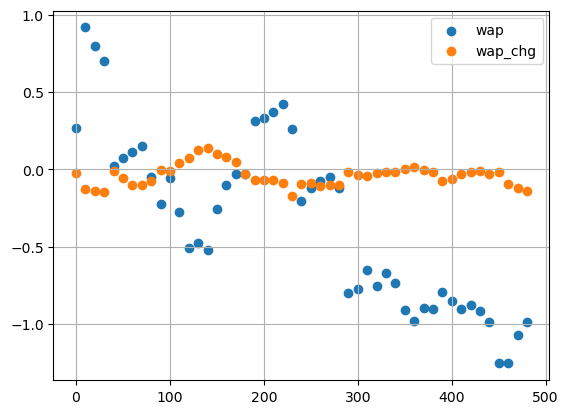

In [89]:
df_184 = df_date[(df_date['pred_wap'].notnull())&(df_date['stock_id']==184)][['stock_id', 'seconds_in_bucket', 'wap', 'wap_chg', 'pred_chg', 'pred_wap', 'raw_wap', 'wap_shift']]

plt.scatter(df_184['seconds_in_bucket'], df_184['wap'], label='wap')
plt.scatter(df_184['seconds_in_bucket'], df_184['wap_chg']*100, label='wap_chg')
plt.legend()
plt.grid()
plt.show()

[100, 75, 15, 94, 78, 180, 59, 89, 197, 38, 160, 99, 77, 18, 1]


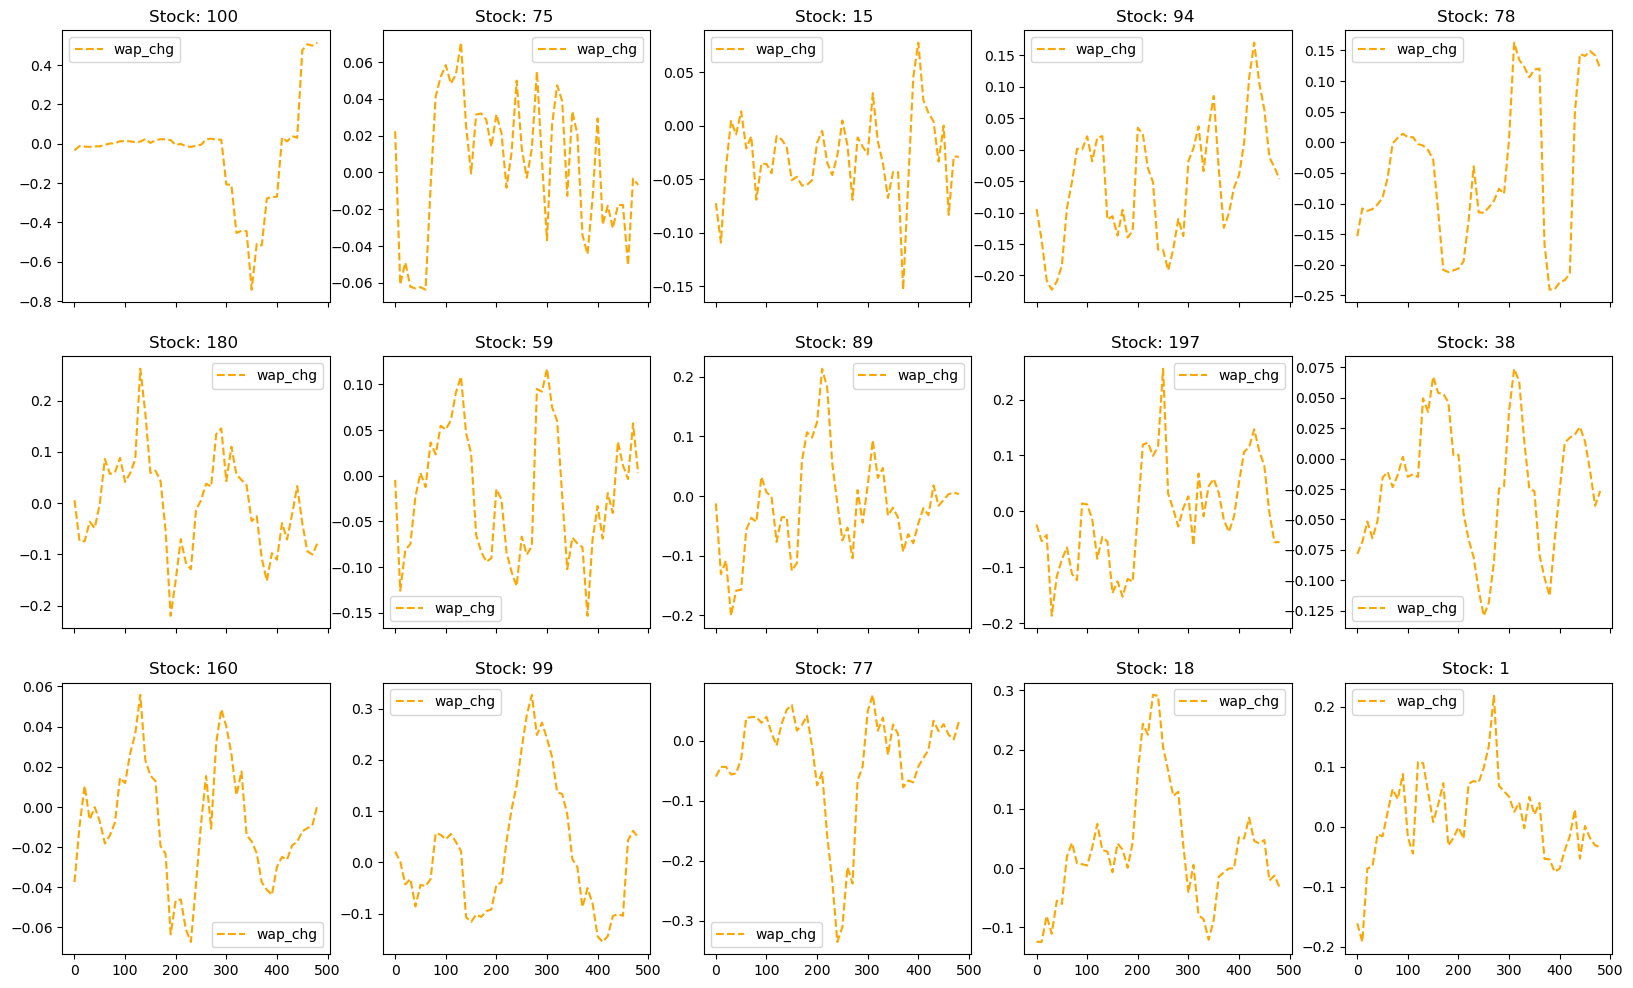

In [90]:
fig, axes = plt.subplots(3, 5, figsize=(20, 12), sharex=True, sharey=False)

# sub_df = df_raw[df_raw['date_id']==df_raw['date_id'].unique()[0]].reset_index(drop=True)

df_date_pred = df_date[df_date['pred_wap'].notnull()].reset_index(drop=True)

stock_list = df_date_pred['stock_id'].unique()

stock_choice = [100, 75,  15,  94,  78, 180,  59,  89, 197,  38, 160,  99,  77,  18, 1] #np.random.choice(stock_list, axes.size, replace=False)

print(stock_choice)

for i,  (ax, stock) in enumerate(zip(axes.flatten(), stock_choice)):
    sub_df = df_date_pred[df_date_pred['stock_id']==stock].reset_index(drop=True)
    ax.plot(sub_df['seconds_in_bucket'], sub_df['wap_chg']*100, label='wap_chg', linestyle='dashed', color='orange')
    # ax.plot(sub_df['pred_wap'], linestyle='solid', label='predict', linewidth=2.5, color='black')
    # ax.plot(sub_df['raw_wap'], label='current', linestyle='dashed', color='orange')
    # ax.plot(sub_df['wap_shift'], label='true', linestyle='dashed', color='red')
    # mae = mean_absolute_error(sub_df['wap_shift']*1e4, sub_df['pred_wap']*1e4)
    # ax.text(0.95, .05, f"MAE: {mean_absolute_error(sub_df['wap_shift']*1e4, sub_df['pred_wap']*1e4):.4f}", transform=ax.transAxes, ha='right', color='green', fontsize=14)
    ax.legend()
    ax.set_title(f"Stock: {stock} ") #

plt.show()

In [91]:
df_list = []
for stock in df_date['stock_id'].unique():
    df_stock = df_date[df_date['stock_id'] == stock].reset_index(drop=True)
    df_stock_wap = df_stock[['seconds_in_bucket', 'wap']]
    df_stock_wap.columns  = ['seconds_in_bucket',  stock]
    df_stock_wap = df_stock_wap.set_index('seconds_in_bucket')
    df_list.append(df_stock_wap) 
    
# df_stock_wap.columns = df_stock_wap.iloc[0]
    
df_stock_wap = pd.concat(df_list, axis=1)

df_stock_wap.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
seconds_in_bucket,,,,,,,,,,,,,,,,,,,,,
0,0.266271,0.266271,0.266271,0.266271,0.266271,0.266271,0.266271,0.266271,0.266271,0.266271,...,0.266271,0.266271,0.266271,0.266271,0.266271,0.266271,0.266271,0.266271,0.266271,0.266271
10,0.008114,0.149335,0.391883,0.276875,-0.088913,0.352138,0.103287,0.693010,0.548638,-0.268062,...,0.566064,0.892625,0.200351,0.216516,0.010005,0.193492,0.019941,0.372010,0.291779,0.295487
20,-0.157317,-0.329014,0.529359,0.216516,-0.180971,0.392550,0.618340,0.468407,0.396258,-0.167290,...,0.046710,0.600322,-0.069003,-0.133070,-0.162916,0.133763,0.012489,0.357106,0.182925,0.059130
30,-0.031668,-0.320931,0.518830,0.306090,0.257558,0.395665,0.643848,0.206542,0.144960,-0.222644,...,0.116968,0.453502,-0.042865,-0.106931,0.248845,0.212771,-0.090136,0.734016,0.324776,0.271832
40,-0.042235,-0.183455,0.454763,0.129425,0.230196,0.423620,0.190377,0.296747,0.143106,-0.381884,...,0.046079,-0.022362,0.061614,-0.340841,0.230196,-0.029184,-0.128732,0.120082,0.266271,0.286811


In [96]:
kmeans.labels_

array([2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 1, 1, 2, 1, 2, 0, 2, 2, 1, 0, 1, 2, 2, 2, 2, 1, 1, 2, 0,
       2, 2, 1, 1, 2, 2, 0, 1, 2, 1, 1, 2, 1, 1, 0, 2, 2, 1, 1, 2, 2, 2,
       2, 1, 2, 0, 2, 1, 2, 2, 1, 1, 1, 0, 0, 2, 2, 0, 2, 1, 0, 2, 0, 2,
       2, 2, 0, 0, 2, 1, 0, 2, 2, 2, 1, 1, 0, 1, 0, 0, 2, 2, 2, 1, 1, 1,
       2, 0, 0, 1, 2, 0, 1, 2, 1, 2, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 2, 2,
       2, 2, 2, 2, 0, 2, 2, 1, 1, 1, 2, 2, 2, 0, 2, 1, 2, 2, 0, 2, 2, 2,
       1, 2, 0, 2, 0, 1, 2, 0, 0, 2, 2, 1, 2, 2, 0, 2, 2, 2, 0, 1, 0, 0,
       0, 2, 0, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1], dtype=int32)

In [97]:
# use kmeans to cluster the stocks
from sklearn.cluster import KMeans

df_stock_wap = df_stock_wap.T 

kmeans = KMeans(n_clusters=3, random_state=0).fit(df_stock_wap)

df_stock_wap['stock_label'] = kmeans.labels_

df_stock_wap.head()

/home/lishi/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


seconds_in_bucket,0,10,20,30,40,50,60,70,80,90,...,400,410,420,430,440,450,460,470,480,stock_label
0,0.266271,0.008114,-0.157317,-0.031668,-0.042235,-0.120019,-0.111306,-0.119389,-0.261203,-0.399902,...,-0.132439,-0.195876,-0.254974,-0.328384,-0.305360,-0.073971,0.029914,-0.054692,-0.056546,2
1,0.266271,0.149335,-0.329014,-0.320931,-0.183455,-0.183455,-0.737067,-1.046834,-0.762575,-0.733953,...,1.038851,0.854734,0.905676,0.319734,0.627016,0.615819,0.604029,0.610258,0.807426,2
2,0.266271,0.391883,0.529359,0.518830,0.454763,0.482718,0.325369,0.232681,0.238909,0.314766,...,-0.009905,-0.063405,-0.048463,-0.058437,0.029284,-0.299761,-0.373801,-0.345179,-0.722126,2
3,0.266271,0.276875,0.216516,0.306090,0.129425,0.137508,0.120712,-0.009905,0.029914,0.061614,...,0.669949,0.564877,0.670617,0.594093,0.679886,0.663128,0.702279,0.640734,0.627683,2
4,0.266271,-0.088913,-0.180971,0.257558,0.230196,-0.069633,-0.015503,-0.006790,0.079039,0.011859,...,-0.544831,-0.605820,-0.741405,-0.699102,-0.738921,-0.841546,-0.648123,-0.769397,-0.767543,2


In [98]:
df_stock_wap[df_stock_wap['stock_label']==0].index

Index([  5,  11,  15,  30,  34,  43,  50,  58,  69,  77,  78,  81,  84,  86,
        90,  91,  94, 100, 102, 103, 111, 112, 115, 125, 129, 136, 145, 150,
       156, 158, 161, 162, 168, 172, 174, 175, 176, 178, 189],
      dtype='int16')

In [ ]:
# plot timeseries of a cluster

fig, axes = plt.subplots(3, 5, figsize=(20, 12), sharex=True, sharey=False)

stock_id_list = df_stock_wap[df_stock_wap['stock_label']==0].index

stock_choice = np.random.choice(stock_id_list, axes.size, replace=False)

for i,  (ax, stock) in enumerate(zip(axes.flatten(), stock_choice)):
    sub_df = df_stock_wap.loc[stock].reset_index()
    ax.plot(sub_df['seconds_in_bucket'], sub_df[stock], label='wap', linestyle='dashed', color='orange')
    ax.legend()
    ax.set_title(f"Stock: {stock} ") #

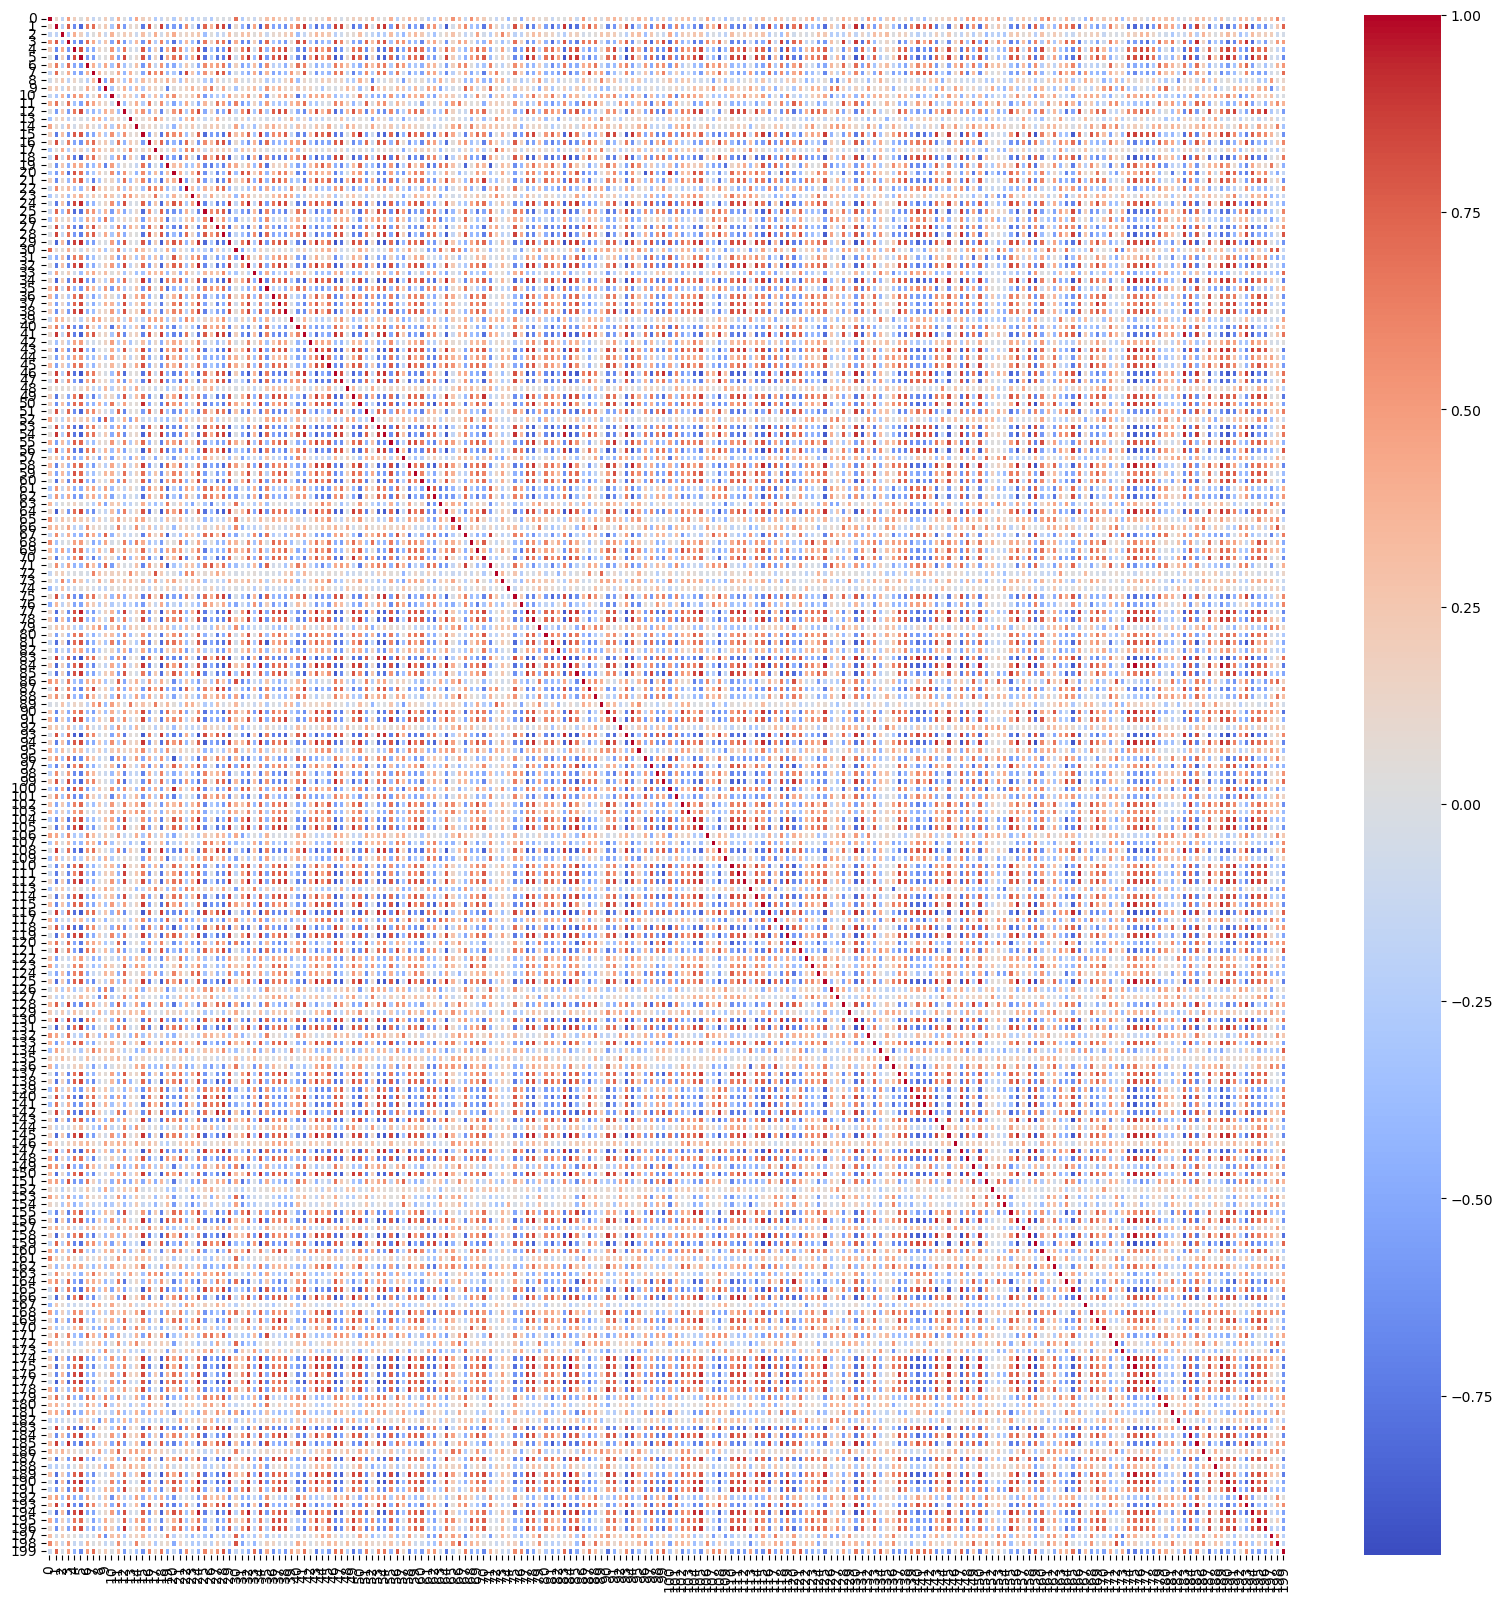

In [94]:
# calculate the correlation matrix
corr = df_stock_wap.corr()

# # plot the heatmap
# plt.figure(figsize=(20, 20))
# sns.heatmap(corr, 
#         xticklabels=corr.columns,
#         yticklabels=corr.columns,
#         cmap='coolwarm',
#         annot=False,
#         linewidth=1)
# plt.show()

In [ ]:
# choose_stock = 153 
# df_test = df[ (df.stock_id == choose_stock) ].copy().reset_index(drop=True)

test_pred_lgb = np.mean([
    lgb_model.predict(df[feature_cols]) for lgb_model in lgb_models
    ], axis=0)

print(test_pred_lgb.shape)

df_raw['wap_chg_pred'] = test_pred_lgb
df_raw['wap_pred'] = df_raw['wap'] * (1 + df_raw['wap_chg_pred'])

df_raw[['date_id', 'stock_id', 'seconds_in_bucket', 'wap', 'wap_pred', 'wap_shift', 'wap_chg', 'wap_chg_pred']]

mae = mean_absolute_error(df_raw['wap_shift']*10000, df_raw['wap_pred']*10000)

print(f"MAE: {mae}")


In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(20, 12), sharex=True, sharey=False)

sub_df = df_raw[df_raw['date_id']==df_raw['date_id'].unique()[0]].reset_index(drop=True)

dates_list = df_raw['date_id'].unique()

dates_choice = np.random.choice(dates_list, axes.size, replace=False)

print(dates_choice)

for i,  (ax, date) in enumerate(zip(axes.flatten(), dates_choice)):
    sub_df = df_raw[df_raw['date_id']==date].reset_index(drop=True)
    ax.plot(sub_df['wap_pred'], linestyle='dashed', label='predict')
    ax.plot(sub_df['wap_shift'], label='true')
    ax.plot(sub_df['wap'], label='current')
    ax.text(0.95, .05, f"MAE: {mean_absolute_error(sub_df['wap_shift']*1e4, sub_df['wap_pred']*1e4):.4f}", transform=ax.transAxes, ha='right', color='green', fontsize=14)
    ax.legend()
    ax.set_title(f"Date: {date}")

plt.show()

In [ ]:
df_importance = pd.DataFrame()
df_importance['feature'] = lgb_models[0].feature_name_
for i, lgb_model in enumerate(lgb_models):
    df_importance[f'importance_{i}'] = lgb_model.feature_importances_

df_importance['importance'] = df_importance[[f'importance_{i}' for i in range(len(lgb_models))]].mean(axis=1)

df_importance = df_importance.sort_values(by='importance', ascending=False).reset_index(drop=True)

df_importance.head(20)

In [ ]:
plt.figure(figsize=(8, 12))
sns.barplot(data=df_importance.head(40), x='importance', y='feature')
plt.axvline(np.percentile(df_importance['importance'], 80), color='red', linestyle='dashed')
plt.show()

In [ ]:
thred = np.percentile(df_importance['importance'], 80)
np.argmax(df_importance['importance']<thred)

In [ ]:
very_importants = df_importance[df_importance['importance']>=thred]['feature'].values
print(len(very_importants))
very_importants

In [ ]:
[ x for x in very_importants if x not in raw_features+v3_features+daily_features ]

In [ ]:
raw_features = [x for x in very_importants if x in prices+sizes+category_cols ]
raw_features

In [ ]:
v3_features = [x for x in very_importants if x.endswith('_5')] 
v3_features

In [ ]:
daily_features = [x for x in very_importants if x.endswith('_5d')]
daily_features

In [ ]:
len(raw_features), len(v3_features), len(daily_features)